In [ ]:
import jax
import jax.numpy as jnp
import ptyrodactyl.electrons as pte
from jaxtyping import Array, Float, Shaped, Int, Complex
import matplotlib.pyplot as plt

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
beam_test_s = jax.random.normal(key, shape=(256, 256), dtype=jnp.complex64)
slice_test_s = jax.random.normal(key, shape=(256, 256), dtype=jnp.complex64)

beam_test_m = jax.random.normal(key, shape=(256, 256, 32), dtype=jnp.complex64)
slice_test_m = jax.random.normal(key, shape=(256, 256, 500), dtype=jnp.complex64)

In [ ]:
test_func_ss = jax.jit(pte.cbed_single_slice_single_beam)
test_func_sm = jax.jit(pte.cbed_single_slice_multi_beam)
test_func_ms = jax.jit(pte.cbed_multi_slice_single_beam)
test_func_mm = jax.jit(pte.cbed_multi_slice_multi_beam)
test_func_ns = jax.jit(pte.cbed_noslice)

In [ ]:
%timeit test_func_ss(slice_test_s, beam_test_s)

50.1 μs ± 1.46 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit test_func_sm(slice_test_s, beam_test_m)

332 μs ± 145 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit test_func_ms(slice_test_m, beam_test_s, jnp.float64(1.003), jnp.float64(60.001), jnp.float64(0.01))

51.2 ms ± 11.7 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit test_func_mm(slice_test_m, beam_test_m, jnp.float64(1.003), jnp.float64(60.001), jnp.float64(0.01))

1.14 s ± 184 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit test_func_ns(slice_test_m, beam_test_m, jnp.float64(1.003), jnp.float64(60.001), jnp.float64(0.01))

1.03 s ± 174 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
cc_sm1 = test_func_ss(slice_test_s, beam_test_s)
cc_sm2 = test_func_ns(
    slice_test_s,
    beam_test_s,
    jnp.float64(1.003),
    jnp.float64(60.001),
    jnp.float64(0.01),
)

In [ ]:
test_func_ns(
    slice_test_m,
    beam_test_m,
    jnp.float64(1.003),
    jnp.float64(60.001),
    jnp.float64(0.01),
)

Array([[3.01474971e-53, 2.99483762e-53, 2.97364396e-53, ...,
        3.00061550e-53, 3.01902223e-53, 3.02394873e-53],
       [7.49687190e-60, 7.49704475e-60, 7.49720485e-60, ...,
        7.49708906e-60, 7.49688446e-60, 7.49679833e-60],
       [1.00686925e-38, 1.00686925e-38, 1.00686925e-38, ...,
        1.00686925e-38, 1.00686925e-38, 1.00686925e-38],
       ...,
       [3.24375101e-54, 3.24374820e-54, 3.24374686e-54, ...,
        3.24376359e-54, 3.24375931e-54, 3.24375509e-54],
       [4.38071617e-41, 4.37999246e-41, 4.37939773e-41, ...,
        4.38292449e-41, 4.38226132e-41, 4.38149855e-41],
       [4.52519887e-57, 4.52516202e-57, 4.52518173e-57, ...,
        4.52516332e-57, 4.52518980e-57, 4.52516827e-57]], dtype=float64)

<matplotlib.image.AxesImage>

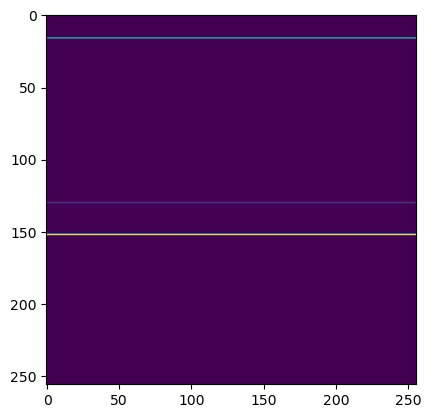

In [ ]:
plt.imshow(
    test_func_ns(
        slice_test_m,
        beam_test_m,
        jnp.float64(1.003),
        jnp.float64(60.001),
        jnp.float64(0.01),
    )
)

In [ ]:
jnp.allclose(jnp.atleast_3d(slice_test_m), slice_test_m)

Array(True, dtype=bool)